In [14]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.laminar_dist import *
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.file.ROI_writer import ROIFileWriter

####################################################################################
# Input (organized into subfolders by date): 
#     ROI files (single cell responses) for each slice and location
#     Stimulation times in stim_times.csv
#     ZDA files
#     electrode.dat, corners_layer.dat (in order: L2/3/4 boundary, L4/5 boundary), corners_barrel.dat
#     paired_pulse_summary.csv
# Output:
#     paired_pulse_summary_edited.csv (values for each ROI, ROI pixel count)
#     Includes classification by layer (L2/3, L4, L5) and barrel (-2, -1, 0, 1, 2) where 0 is electrode barrel
####################################################################################

In [15]:
# Load data, not from Drive for Desktop since PhotoZ complains about loading zda from Drive
data_dir = "C:/Users/ajansson/Desktop/2022-09-02_Usable/"
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Anna's/"
date_format = 'yyyy-mm-dd'
# measure window settings ( in frames )
pre_window_offset = 0
window_width = 40

input_csv = data_dir + 'paired_pulse_summary.csv'
output_csv = data_dir + 'paired_pulse_summary_edited.csv'
overwrite_intermed_dat_files = False  # whether to re-save value files

enable_photoZ_interaction = False
initialize_photoZ = False

# load the all-data CSV dir
df = pd.read_csv(input_csv)
df = pd.DataFrame(df)

In [16]:
# set up PhotoZ (open it manually)
if enable_photoZ_interaction:
    aPhz = AutoPhotoZ(data_dir=data_dir)
    if initialize_photoZ:
        aPhz.prepare_photoZ()

def get_value_filename(subdir, filename_id, stim_time_idx, roi_id_start, roi_id_end, filename_end):
    f = subdir + "/" + filename_id 
    f += str(stim_time_idx) + "_"
    f += str(roi_id_start) 
    f += "to" + str(roi_id_end) + "_" + filename_end
    return f

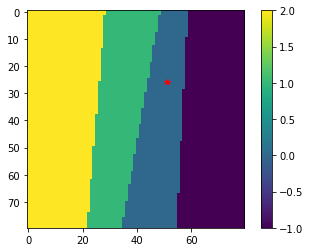

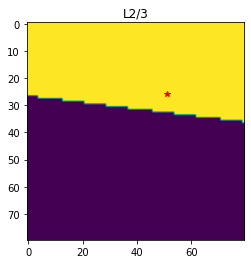

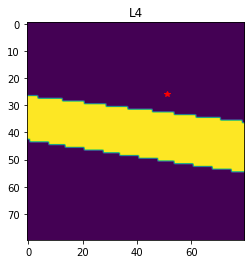

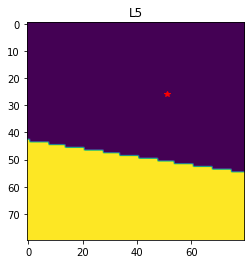



scraping data from  02_01_03.zda using 02-01_ROIs_1_to_26.dat on date: 9/2/2022
{'Date': ['9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022'], 'Slice_Loc_Rec': ['9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022', '9/2/2022'], 'ROI ID': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26], 'Stim Time #1': [90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90], 'Stim Time #2': [130, 130, 130, 130

FileNotFoundError: [Errno 2] No such file or directory: "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Anna's/2022-09-02_Usable\\selected_zda/maxAmp_1_1to26_02_01_03.dat"

In [31]:
is_measure_window_width_set = window_width
for subdir, dirs, files in os.walk(data_dir):
    zda_files = []
    roi_files = {}  # map slice number to ROIs file
    
    if 'Usable' not in subdir:
        continue
    if 'selected_zda' not in subdir or 'hidden' in subdir:
        continue
    
    # locate important file names
    for f in files:
        if f.endswith(".zda"):
            zda_files.append(f)
        if 'ROIs' in f[-22:] and f.endswith('.dat'):
            metadata = f.replace('.dat','').split("_ROIs_")
            slice_no, loc_no = [int(x) for x in metadata[0].split("-")]
            if slice_no not in roi_files:
                roi_files[slice_no] = {}
            if loc_no not in roi_files[slice_no]:
                roi_files[slice_no][loc_no] = []
            start, end = [int(x) for x in metadata[1].split("_to_")]
            roi_files[slice_no][loc_no].append(
                {"start": start,
                "end": end,
                "filename": f}
            )
    
    # open stimtimes.csv file for this subdir
    stim_times_df = pd.read_csv(subdir + "/stimtimes.csv",
                                header=None,
                                names=['Rec_ID', 'Stim_Time_1', 'Stim_Time_2'])
   
    if len(roi_files) < 1 or len(zda_files) < 1:
        continue
    
    for zda_file in zda_files:
        rec_id = zda_file.split('.')[0]
            
        # determine date and slice, loc, rec
        aPhz = AutoPhotoZ(data_dir=subdir)
        trace_values_to_save = {
            'Max Amp': {'method': aPhz.select_maxamp_trace_value, 
                         'filename_id': "maxAmp_"},
            'Max Amp / SD': {'method': aPhz.select_SNR_trace_value, 
                         'filename_id': 'SNR_'},
            'Half Amp Latency': {'method': aPhz.select_latency_trace_value, 
                         'filename_id': "latency_"},
            'Half Width': {'method': aPhz.select_half_width_trace_value, 
                         'filename_id': 'halfWidth_'},
            'Max Amp Latency': {'method': aPhz.select_peaktime_trace_value, 
                         'filename_id': 'maxAmpLatency_'},
            'Half Rise Time': {'method': aPhz.select_half_rise_time_trace_value, 
                         'filename_id': 'riseTime_'},
            'Half Decay Time': {'method': aPhz.select_half_decay_time_trace_value, 
                         'filename_id': 'decayTime_'}
        }

        is_zda_file_open = False
        
        date = subdir.split("_Usable")[0][-10:]
        date = [int(x) for x in date.split("-")]
        if date_format != 'yyyy-mm-dd':
            date[2] += 2000  # full year format
        else:
            date = [date[1], date[2], date[0]]
        date = "/".join([str(d) for d in date])
        
        slice_no, loc_no, rec_no = [int(x) for x in rec_id.split("_")]
        
        # find stim times for this recording
        stim_times_rec = stim_times_df[stim_times_df['Rec_ID'] == rec_id]
        stim_time_1 = int(stim_times_rec['Stim_Time_1'])
        stim_time_2 = int(stim_times_rec['Stim_Time_2'])
        
        # find the user annotations for this recording
        output_dir = subdir + "/analysis" + rec_id + "/"
        electrode_file = output_dir + "electrode.dat"
        corners_layer_file = output_dir + "corners_layer.dat"
        corners_barrel_file = output_dir + "corners_barrel.dat"
        
        # build the layer/barrel maps for future use
        barrel_layer_axes = []  # list of Line objects, first 2 are layer boundaries, rest are barrel boundaries
        for la_file in [corners_layer_file, corners_barrel_file]:
            with open(la_file, 'r') as f:
                lines = f.readlines() 
            roi_px_ct = int(lines[2]) - 1 
            corners = [int(x) for x in lines[4:]] # the last lines are diode numbers of corners
            if len(corners) != roi_px_ct:
                raise Exception("Likely an error processing corners. Expected " + 
                                str(roi_px_ct) + " pixels.")
            layer_axes = LayerAxes(corners[:4], verbose=False, obey_initial_order=True)
            laminar_axis, laminar_axis_2 = layer_axes.get_layer_axes()
            barrel_layer_axes.append(laminar_axis)
            barrel_layer_axes.append(laminar_axis_2)

            rest_of_corners = LaminarROI(corners[4:]).get_points()
            for j in range(0, len(rest_of_corners), 2):
                if len(rest_of_corners) > j+1:
                    barrel_layer_axes.append(Line(rest_of_corners[j], rest_of_corners[j+1]))

        # Now we will divide into L2/3, L4, L5 and barrels
        w, h = LaminarROI([]).get_dimensions()
        layer_px_map = {"L2/3": np.zeros((w, h)),
                        "L4": np.zeros((w, h)),
                        "L5": np.zeros((w, h))}
        left_of_L234_map = np.zeros((w, h))
        pt1 = None  # find a point that is NOT in L4

        # first two axes are guaranteed to be LAYER divisions
        L234_axis = barrel_layer_axes[0]
        L45_axis = barrel_layer_axes[1]
        for i in range(w):
            for j in range(h):
                left_of_L234 = L234_axis.is_point_left_of_line([i, j])
                left_of_L45 = L45_axis.is_point_left_of_line([i, j])
                if left_of_L234 != left_of_L45:
                    layer_px_map["L4"][i, j] += 1
                else:
                    # All the points NOT in L4
                    if left_of_L234:
                        left_of_L234_map[i, j] += 1
                        pt1 = [i, j]  # this is NOT in L4
                
        # build L2/3 and L5 pixel maps based on PT1 distance to L234_axis and L45_axis
        dist_to_L234 = L234_axis.get_distance_to_point(pt1)
        dist_to_L45 = L45_axis.get_distance_to_point(pt1)
        if dist_to_L234 < dist_to_L45:
            # then pt1 is in L2/3, and then so is everything in left_of_L234_map
            layer_px_map["L2/3"] = left_of_L234_map
            layer_px_map["L5"] = np.ones((w, h)) - left_of_L234_map - layer_px_map["L4"]
        elif dist_to_L234 > dist_to_L45:
            # then pt1 is in L5, and then so is everything in left_of_L234_map
            layer_px_map["L5"] = left_of_L234_map
            layer_px_map["L2/3"] = np.ones((w, h)) - left_of_L234_map - layer_px_map["L4"]
        else:
            print("Sample point,", pt1, "is equidistant to both L2/3/4 and L4/5 boundaries:", 
                  dist_to_L234,
                  dist_to_L45)
            raise Exception("Could not distinguish L2/3 from L5.")
            
        # read in electrode location
        with open(electrode_file, 'r') as f:
            lines = f.readlines()
        stim_pt = int(lines[-1]) # last line is always electrode location
        aux_obj = LaminarROI([stim_pt]).get_points()
        stim_pt = aux_obj[0]  # should be a list of len 2, representing px location [x, y]
        
        # build barrel pixel map based on distance to electrode
        barrel_px_map = np.zeros((w, h))
        for axis in barrel_layer_axes[2:]: # rest of these are barrel divisions
            for i in range(w):
                for j in range(h):
                    if axis.is_point_left_of_line([i, j]):
                        barrel_px_map[i, j] += 1
        
        # zero everything out so barrel_px_map is then the barrel ID for each point
        stim_baseline = barrel_px_map[stim_pt[0], stim_pt[1]]
        for i in range(w):
            for j in range(h):
                barrel_px_map[i, j] -= stim_baseline
                
        # visualize the barrel and layer maps
        plt.imshow(np.transpose(barrel_px_map), interpolation='none')
        plt.plot(stim_pt[0], stim_pt[1], marker="*", color='red')
        plt.colorbar()
        plt.show()
        for ke in layer_px_map:
            plt.imshow(np.transpose(layer_px_map[ke]))
            plt.plot(stim_pt[0], stim_pt[1], marker="*", color='red')
            plt.title(ke)
            plt.show()
            
        for roi_grp_idx in range(len(roi_files[slice_no][loc_no])):
            roi_file = roi_files[slice_no][loc_no][roi_grp_idx]['filename']
            roi_id_start = roi_files[slice_no][loc_no][roi_grp_idx]['start']
            roi_id_end = roi_files[slice_no][loc_no][roi_grp_idx]['end']
            print("\n\nscraping data from ", zda_file, 
                  "using", roi_file, "on date:", date)

            filename_end = rec_id + '.dat'
            
            # find # pixels in ROI 
            rfr = ROIFileReader(subdir + "/" + roi_file)
            roi_list = rfr.get_roi_list()
            n_pixels = [len(r) for r in roi_list]
            
            # see if we can skip this entire ROI group (if files already exist)
            if not overwrite_intermed_dat_files:
                are_files_complete = True
                for trace_val_type in trace_values_to_save:
                    for stim_time_idx in range(1,3):
                        value_filename = get_value_filename(subdir,
                                                            trace_values_to_save[trace_val_type]['filename_id'], 
                                                            stim_time_idx, 
                                                            roi_id_start, 
                                                            roi_id_end, 
                                                            filename_end)
                        # may be able to skip saving file
                        if not os.path.exists(value_filename):
                            are_files_complete = False
                            break
                    if not are_files_complete:
                        break
            if are_files_complete:
                print("We already have all the value files for this setup. Skipping...")
                
            # open the PhotoZ file
            if enable_photoZ_interaction and not is_zda_file_open and not are_files_complete:
                aPhz.select_PhotoZ()
                aPhz.open_zda_file(subdir + "/" + zda_file)
                is_zda_file_open = True

            # open roi file in photoZ
            if enable_photoZ_interaction and not are_files_complete:
                aPhz.select_roi_tab()
                aPhz.open_roi_file(subdir + "/" + roi_file)
                
            for stim_time_idx in range(1,3):
                stim_time = [stim_time_1, stim_time_2][stim_time_idx-1]
        
                # set the stim window
                if enable_photoZ_interaction and not are_files_complete:
                    # is_measure_window_width_set is equal to window_width if window not yet set.
                    aPhz.set_measure_window(stim_time - pre_window_offset, 
                                            is_measure_window_width_set)
                    is_measure_window_width_set = None  # no need to set in future


                # save trace values from PhotoZ
                for trace_val_type in trace_values_to_save:
                    value_filename = get_value_filename(subdir,
                                                        trace_values_to_save[trace_val_type]['filename_id'], 
                                                        stim_time_idx, 
                                                        roi_id_start, 
                                                        roi_id_end, 
                                                        filename_end)
                    # may be able to skip saving file
                    if not (os.path.exists(value_filename) and not overwrite_intermed_dat_files):
                        value_method = trace_values_to_save[trace_val_type]['method']
                        if enable_photoZ_interaction and not are_files_complete:
                            value_method()
                            aPhz.save_trace_values(value_filename)
                    trace_values_to_save[trace_val_type]['full_path_filename_' + str(stim_time_idx)] = value_filename

            ###############################################################
            # classifying ROIs by barrel (barrel_px_map) and layer (layer_px_map)
            roi_layer_classes = []
            roi_barrel_classes = []
            for rr in roi_list:
                rr_pts = LaminarROI([]).diode_num_to_points(rr)
                
                # Classify which layer. if borderline, "Edge"
                layer_classification = "Edge"
                for layer_key in layer_px_map:
                    is_roi_in_layer = True
                    for pt in rr_pts:
                        x, y = pt
                        if layer_px_map[layer_key][x, y] != 1:
                            is_roi_in_layer = False
                            break
                    if is_roi_in_layer:
                        layer_classification = layer_key
                        break
                roi_layer_classes.append(layer_classification)
                
                # Classify which barrel. if borderline, "Edge"
                barrel_classification = "Edge"
                barrel_ids = [int(barrel_px_map[pt[0], pt[1]]) for pt in rr_pts]
                if all([bid == barrel_ids[0] for bid in barrel_ids]):
                    barrel_classification = barrel_ids[0]
                roi_barrel_classes.append(barrel_classification)
                        
            ###############################################################
            # WRITING NEW CSV ROWS
            new_rows = {"Date" : [date for i in range(roi_id_start, roi_id_end+1)], 
                        "Slice_Loc_Rec": [date for i in range(roi_id_start, roi_id_end+1)],
                        "ROI ID":  [i for i in range(roi_id_start, roi_id_end+1)],
                        "Stim Time #1":  [stim_time_1 for i in range(roi_id_start, roi_id_end+1)],
                        "Stim Time #2": [stim_time_2 for i in range(roi_id_start, roi_id_end+1)],
                        "Pixel Count": n_pixels[:roi_id_end+1- roi_id_start],
                        "Layer": roi_layer_classes,
                        "Barrel": roi_barrel_classes}
            print(new_rows)
            
            # sanity check on ROI file lengths
            if len(n_pixels) > roi_id_end+1- roi_id_start:
                print(n_pixels, len(n_pixels))

            for trace_val_type in trace_values_to_save:
                for stim_time_idx in range(1,3):
                    trace_stim_idx = trace_val_type + " #" + str(stim_time_idx)
                    if trace_stim_idx not in new_rows:
                        new_rows[trace_stim_idx] = []
                    if trace_stim_idx not in df.columns:
                        df[trace_stim_idx] = []
                    intermed_df = pd.read_csv(trace_values_to_save[trace_val_type]['full_path_filename_' + str(stim_time_idx)],
                                              sep='\t',
                                              header=None,
                                              names=['Index',  'Values'])
                    for i in range(roi_id_end+1-roi_id_start):
                        v = intermed_df['Values'][i]
                        new_rows[trace_stim_idx].append(v)
            
            for key in new_rows:
                print(key, len(new_rows[key]))
            print(df.columns)
                
            nrs = pd.DataFrame.from_dict(new_rows)
            print(nrs.shape, df.shape)
            df = pd.concat([nrs, df])


In [ ]:
# divide amplitudes by 1000
df['Max Amp #1'] /= 1000
df['Max Amp #2'] /= 1000

df['Interpulse Interval'] =  (df['Stim Time #2'] - df['Stim Time #1']) / df['Stim Time #2']

# add paired pulse ratio column
df['Paired Pulse Ratio'] = df['Max Amp #2'] / df['Max Amp #1']

# write the pandas dataframe back to csv
df.to_csv(output_csv, index=False)

In [ ]:
df